# Training a Linear Model to Predict Length of Stay

The [Population Health Management Solution](https://github.com/Azure/cortana-intelligence-population-health-management/tree/master/Azure%20Data%20Lake) uses U-SQL queries in Data Lake Analytics to apply trained models to input data. The solution copies pre-trained models to an Azure Data Lake Store account (under the folder `forphmdeploymentbyadf`) for this purpose. In this notebook, we provide the code demonstrating how xgboost models can be created for this purpose. (See the notebook named "Length Of Stay Models -- lm" for the code used to create the linear models employed by the solution.)

Running this notebook will create the models used in this solution and store them in a folder named `myxgboostLOSmodelsfolder` in your current working directory.

## Outline <a id="BackToTop"></a>

  * [Problem Description](#probdesc)
  * [Get Data](#getdata)
  * [Data Description](#datadesc)
  * [Data Exploration](#dataexp)
  * [Feature Engineering](#featureeng)
  * [Create the Model](#model)
  * [Results](#results)

## Problem Description  <a id="probdesc"></a>
### Why predict the length of a hospital stay?

Recent legislative changes have standardized payments for procedures performed, regardless of the number of days a patient actually spends in the hospital. Hospitals are therefore strongly incentivized to use resources more efficiently and find ways to accommodate more patients with the same volume of resources. An accurate prediction of each patient's length of stay can help hospitals:
1. Manage bed occupancy 
2. Effectively schedule elective admissions   
3. Improve patient satisfaction during their hospital stay   

Extended lengths of stay costs hospitals millions of dollars a year. By identifying patients at risk for an extended stay, they can take proactive measures to formulate a treatment plan to reduce the expected length of stay.

### When should the prediction be used?  

Hospitals want to predict the length of each patient's stay at the time of admission and provide this information to the admitting nurse or staff. Our model is trained using encounter-level records for a million or so patients from 23 hospitals (obtained from the Healthcare Cost and Utilization Project, or [HCUP](https://www.hcup-us.ahrq.gov/)) and is suitable for use on similar patient populations, though we recommend that hospitals retrain the model using their own historical patient data for best results. To be applied to newly-admitted patients, the model must be trained using only features that are available for each patient at the time of their admission.

 [Back To Top](#BackToTop)

<a id="getdata"></a>
## Get Data

Here, we download copies of the training data (~2 GB) from the web to your current working directory. This will likely take a few minutes, depending on your bandwidth:

In [ ]:
# clear workspace and collect garbage
rm(list=ls())
gc()

Sys.time()
url1 <- "https://phm.blob.core.windows.net/models/core_data.csv"
url2 <- "https://phm.blob.core.windows.net/models/charges_data.csv"
url3 <- "https://phm.blob.core.windows.net/models/severity_data.csv"
url4 <- "https://phm.blob.core.windows.net/models/dxpr_data.csv"

pathd <- getwd()
dest1 <- paste(pathd, "/core_data.csv", sep='')
dest2 <- paste(pathd, "/charges_data.csv", sep='')
dest3 <- paste(pathd, "/severity_data.csv", sep='')
dest4 <- paste(pathd, "/dxpr_data.csv", sep='')

download.file(url1, dest1)
download.file(url2, dest2)
download.file(url3, dest3)
download.file(url4, dest4)
Sys.time()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,453474.0,24.3,750400.0,40.1,592000.0,31.7
Vcells,633079.0,4.9,1308461.0,10.0,1008894.0,7.7


Warning message:
In as.POSIXlt.POSIXct(x, tz): unable to identify current timezone 'C':
please set environment variable 'TZ'Warning message:
In as.POSIXlt.POSIXct(x, tz): unknown timezone 'localtime'

[1] "2017-06-15 05:06:30 GMT"

We now read the input files into memory (this will likely take a few minutes, given the combined size of the files):

In [54]:
Sys.time()
dat_core <- read.csv(dest1)
dat_chrg <- read.csv(dest2)
dat_sevr <- read.csv(dest3)
dat_dxpr <- read.csv(dest4)
Sys.time()

[1] "2017-06-15 05:09:00 GMT"

[1] "2017-06-15 05:13:22 GMT"

Confirm that the input files were downloaded and read fully by checking the data dimensions:

In [55]:
dim(dat_core) # expected: 1103172 x 248
dim(dat_chrg) # expected: 1103172 x 155
dim(dat_sevr) # expected: 1103172 x 30
dim(dat_dxpr) # expected: 1103172 x 180

[1] 1103172     248

[1] 1103172     155

[1] 1103172      30

[1] 1103172     180

Merge the input files and delete the intermediate variables:

In [56]:
dat <- merge(merge(merge(dat_sevr, dat_chrg, by="KEY"), dat_core, by="KEY"), dat_dxpr, by="KEY")
dim(dat) # expected: 1103172 x 610
rm(dat_core, dat_chrg, dat_sevr, dat_dxpr)

[1] 1103172     610

 [Back To Top](#BackToTop)

<a id="datadesc"></a>
## Data Description  

We list the columns contained in the dataset below. A full description of the columns in this dataset can be found in the [data dictionary](https://www.hcup-us.ahrq.gov/db/state/siddist/siddistvarnote2013.jsp).

In [57]:
names(dat)

[1] "KEY"                  "CM_AIDS"              "CM_ALCOHOL"          
  [4] "CM_ANEMDEF"           "CM_ARTH"              "CM_BLDLOSS"          
  [7] "CM_CHF"               "CM_CHRNLUNG"          "CM_COAG"             
 [10] "CM_DEPRESS"           "CM_DM"                "CM_DMCX"             
 [13] "CM_DRUG"              "CM_HTN_C"             "CM_HYPOTHY"          
 [16] "CM_LIVER"             "CM_LYMPH"             "CM_LYTES"            
 [19] "CM_METS"              "CM_NEURO"             "CM_OBESE"            
 [22] "CM_PARA"              "CM_PERIVASC"          "CM_PSYCH"            
 [25] "CM_PULMCIRC"          "CM_RENLFAIL"          "CM_TUMOR"            
 [28] "CM_ULCER"             "CM_VALVE"             "CM_WGHTLOSS"         
 [31] "NREVCD"               "REVCD1"               "REVCD2"              
 [34] "REVCD3"               "REVCD4"               "REVCD5"              
 [37] "REVCD6"               "REVCD7"               "REVCD8"              
 [40] "REVCD9"               "REVCD10"              "REVCD11"             
 [43] "REVCD12"              "REVCD13"              "REVCD14"             
 [46] "REVCD15"              "REVCD16"              "REVCD17"             
 [49] "REVCD18"              "REVCD19"              "REVCD20"             
 [52] "REVCD21"              "REVCD22"              "REVCD23"             
 [55] "REVCD24"              "REVCD25"              "REVCD26"             
 [58] "REVCD27"              "REVCD28"              "REVCD29"             
 [61] "REVCD30"              "REVCD31"              "REVCD32"             
 [64] "REVCD33"              "REVCD34"              "REVCD35"             
 [67] "REVCD36"              "REVCD37"              "REVCD38"             
 [70] "REVCD39"              "REVCD40"              "REVCD41"             
 [73] "REVCD42"              "REVCD43"              "REVCD44"             
 [76] "REVCD45"              "REVCD46"              "REVCD47"             
 [79] "REVCD48"              "REVCD49"              "REVCD50"             
 [82] "REVCD51"              "REVCHG1"              "REVCHG2"             
 [85] "REVCHG3"              "REVCHG4"              "REVCHG5"             
 [88] "REVCHG6"              "REVCHG7"              "REVCHG8"             
 [91] "REVCHG9"              "REVCHG10"             "REVCHG11"            
 [94] "REVCHG12"             "REVCHG13"             "REVCHG14"            
 [97] "REVCHG15"             "REVCHG16"             "REVCHG17"            
[100] "REVCHG18"             "REVCHG19"             "REVCHG20"            
[103] "REVCHG21"             "REVCHG22"             "REVCHG23"            
[106] "REVCHG24"             "REVCHG25"             "REVCHG26"            
[109] "REVCHG27"             "REVCHG28"             "REVCHG29"            
[112] "REVCHG30"             "REVCHG31"             "REVCHG32"            
[115] "REVCHG33"             "REVCHG34"             "REVCHG35"            
[118] "REVCHG36"             "REVCHG37"             "REVCHG38"            
[121] "REVCHG39"             "REVCHG40"             "REVCHG41"            
[124] "REVCHG42"             "REVCHG43"             "REVCHG44"            
[127] "REVCHG45"             "REVCHG46"             "REVCHG47"            
[130] "REVCHG48"             "REVCHG49"             "REVCHG50"            
[133] "REVCHG51"             "UNIT1"                "UNIT2"               
[136] "UNIT3"                "UNIT4"                "UNIT5"               
[139] "UNIT6"                "UNIT7"                "UNIT8"               
[142] "UNIT9"                "UNIT10"               "UNIT11"              
[145] "UNIT12"               "UNIT13"               "UNIT14"              
[148] "UNIT15"               "UNIT16"               "UNIT17"              
[151] "UNIT18"               "UNIT19"               "UNIT20"              
[154] "UNIT21"               "UNIT22"               "UNIT23"              
[157] "UNIT24"               "UNIT25"               "UNIT26"              
[160] "UNIT27"             

We perform a few sanity checks on the integrity of the downloaded data, ensuring that the month column contains the values for months and so on:

In [58]:
unique(dat$AYEAR) 
unique(dat$AMONTH) 
length(unique(dat$AMONTH))
unique(dat$FEMALE)

[1] 2016

[1]  8  3  9  5  4  6 12  2  1 10  7 11

[1] 12

[1] Female Male  
Levels: Female Male

The dataset currently contains 610 columns, but some are not suitable for use with our model because they are not available at the time of a patient's admission (when the length-of-stay prediction will be made). We will use just the following 135 columns for building the length-of-stay model: 

In [59]:
cols_demographic <- c('AGE', 'FEMALE', 'RACE', 'MEDINCSTQ', 'PSTATE', 'ZIP', 'HOSPST', 'PAY1', 'PAY2', 'PAY3') 
cols_admitinfo <- c('KEY', 'VisitLink', 'DSHOSPID', 'ATYPE', 'AMONTH', 'PointOfOriginUB04', 'TRAN_IN')
cols_Diagnosis_present_on_admission <- grep('DXPOA', names(dat), value=T)
cols_ECode_present_on_admission <- grep('E_POA', names(dat), value=T)
cols_ICD9_CM_Chronic_Condition_Indicators <- grep('^CHRON[0-9]', names(dat), value=T)
cols_Chronic_Condition_Indicators_BodySystem <- grep('^CHRONB', names(dat), value=T)
cols_comorbidity_measure_ICD9_CMcodes <- grep('^CM_', names(dat), value=T)
cols_primaryDiagnosis <- c('DX1', 'DXCCS1', 'DXMCCS1')
cols_counts <- c('NDX', 'NCHRONIC')
cols_Target <- c('LOS')
cols4los <- c(cols_demographic, cols_admitinfo, cols_Diagnosis_present_on_admission, cols_ECode_present_on_admission, 
              cols_ICD9_CM_Chronic_Condition_Indicators, cols_Chronic_Condition_Indicators_BodySystem,
              cols_comorbidity_measure_ICD9_CMcodes, cols_primaryDiagnosis, cols_counts, cols_Target)
length(cols4los)

[1] 135

We now reduce the dataset to just the columns of interest:

In [99]:
dat4los <- dat[,cols4los]
dim(dat4los)

[1] 1103172     135

 [Back To Top](#BackToTop)

## Data Exploration  <a id="dataexp"></a>

### Categorical features

The dataset contains 13 categorical features.   
'DSHOSPID', 'FEMALE', 'RACE', 'ATYPE', 'AMONTH', 'PointOfOriginUB04', 'TRAN_IN', 'MEDINCSTQ', 'PSTATE', 'PAY1', 'DXCCS1', 'DXMCCS1', 'ZIP'  
Below, we enumerate some of these features and show their possible values:

In [62]:
cat_cols <- c('DSHOSPID', 'FEMALE', 'RACE', 'ATYPE', 'AMONTH', 'PointOfOriginUB04', 'TRAN_IN',
              'MEDINCSTQ', 'PSTATE', 'PAY1', 'DXMCCS1')

apply(dat4los[, cat_cols], 2, FUN=function(x){length(unique(x))})
apply(dat4los[, cat_cols], 2, FUN=function(x){unique(x)})

DSHOSPID            FEMALE              RACE             ATYPE 
               23                 2                 7                 5 
           AMONTH PointOfOriginUB04           TRAN_IN         MEDINCSTQ 
               12                12                 3                 4 
           PSTATE              PAY1           DXMCCS1 
               25                 6                19

$DSHOSPID
 [1] "hosp_17" "hosp_13" "hosp_11" "hosp_22" "hosp_9"  "hosp_1"  "hosp_14"
 [8] "hosp_23" "hosp_6"  "hosp_16" "hosp_2"  "hosp_5"  "hosp_12" "hosp_18"
[15] "hosp_4"  "hosp_15" "hosp_3"  "hosp_19" "hosp_8"  "hosp_21" "hosp_10"
[22] "hosp_20" "hosp_7" 

$FEMALE
[1] "Female" "Male"  

$RACE
[1] " 1" "-9" " 2" " 5" " 4" " 3" " 6"

$ATYPE
[1] "ATYPE_2" "ATYPE_1" "ATYPE_3" "ATYPE_4" "ATYPE_5"

$AMONTH
 [1] " 8" " 3" " 9" " 5" " 4" " 6" "12" " 2" " 1" "10" " 7" "11"

$PointOfOriginUB04
 [1] "4" "1" "6" "8" "5" "2" "7" "B" "E" "C" "D" "F"

$TRAN_IN
[1] "1" "0" "2"

$MEDINCSTQ
[1] "1" "3" "2" "4"

$PSTATE
 [1] "GA" "CO" "IN" "WA" "IL" "NY" "MS" "SD" "VT" "MA" "RI" "MI" "WV" "CT" "NJ"
[16] "MO" "HI" "NE" "MD" "AZ" "AK" "NM" "MT" "AR" "VA"

$PAY1
[1] "2" "3" "6" "1" "4" "5"

$DXMCCS1
 [1] "11" " 9" " 2" "15" " 5" "13" "10" "16" " 4" NA   "14" " 7" " 6" " 8" " 3"
[16] " 1" "17" "12" "18"

### Distribution of Length Of Stay

Below, we plot the distribution of values for our model's prediction target, `LOS` (length of stay): 

0.7
1.9
3.1
4.3
5.5
6.7


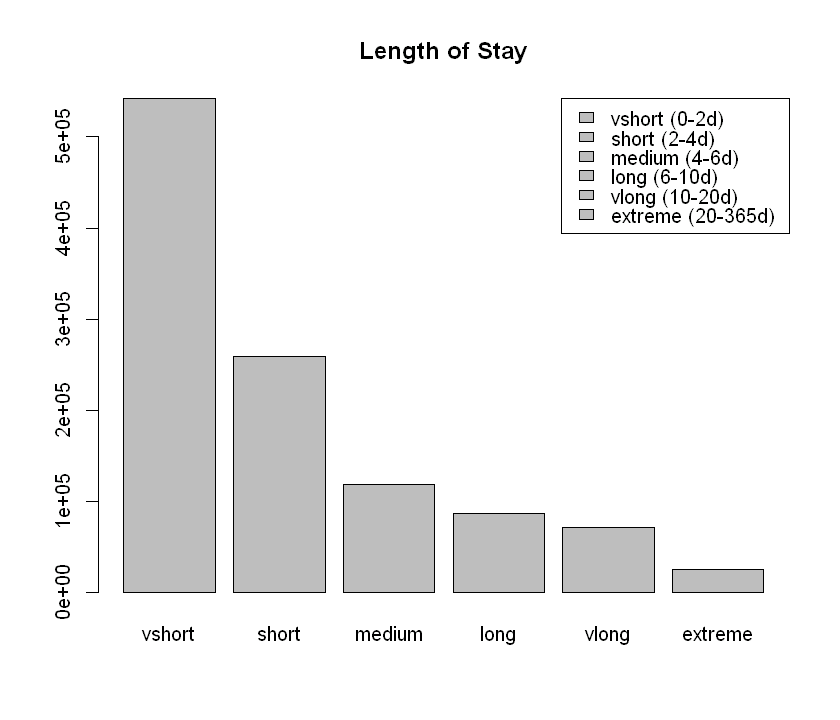

In [69]:
losbreaks <- c(0, 2, 4, 6, 10, 20, 365)
loslabels <- c('vshort', 'short', 'medium', 'long', 'vlong', 'extreme')
losdist   <- data.frame(table(cut(as.numeric(dat4los$LOS), breaks=losbreaks, labels=loslabels)))

options(repr.plot.width=7, repr.plot.height=6)

bp <- barplot(losdist$Freq, names.arg=losdist$Var1, main="Length of Stay")
bp
legend("topright",
       fill=c("grey"),
       c('vshort (0-2d)', 'short (2-4d)', 'medium (4-6d)', 'long (6-10d)', 'vlong (10-20d)', 'extreme (20-365d)'))

 [Back To Top](#BackToTop)

<a id="featureeng"></a>
## Feature Engineering

Create some additional features from raw data.

### Count diagnoses present on admission

Find the columns named DXPOA1 - DXPOA25, convert them from string to integer values, perform the count, then delete the original DXPOA columns:

In [70]:
indDXPOA <- grep('DXPOA', names(dat4los))
dat4los[, indDXPOA] <- apply(dat4los[, indDXPOA], 2, FUN=function(x){ifelse(x=='Y', 1, x)}) 
dat4los[, indDXPOA] <- apply(dat4los[, indDXPOA], 2, FUN=function(x){ifelse(x==1, x, 0)})

dat4los$num_DXPOA <- apply(dat4los[, indDXPOA], 1, FUN=function(x){length(x[x=='1'])})
dat4los  <- dat4los[, -indDXPOA]

### Count external causes of injury present on admission

Delete the original binary indicators.

In [71]:
indE_POA <- grep('E_POA', names(dat4los))
dat4los[, indE_POA] <- apply(dat4los[, indE_POA], 2, FUN=function(x){ifelse(x=='Y', 1, x)})
dat4los[, indE_POA] <- apply(dat4los[, indE_POA], 2, FUN=function(x){ifelse(x==1, x, 0)})

dat4los$num_E_POA <- apply(dat4los[, indE_POA], 1, FUN=function(x){length(x[x=='1'])})
dat4los <- dat4los[, -indE_POA]

### Count the number of body systems affected by chronic conditions

Delete the original binary indicators (both at the body system and individual condition levels).

In [72]:
indchronB <- grep('^CHRONB[0-9]', names(dat4los))
dat4los$num_uCHRONB <- apply(dat4los[indchronB], 1, FUN=function(x){length(unique(x[!is.na(x)]))})
dat4los   <- dat4los[, -indchronB]

# Won't use these for anything either
indCHRON <- grep('^CHRON[0-9]', names(dat4los))
dat4los  <- dat4los[, -indCHRON]

### Count number of payers (medicare, medicaid, private insurance, ...)

Delete the mostly-missing columns `PAY2` and `PAY3` when done.

In [73]:
indPAY <- grep('PAY', names(dat4los), value=T)
dat4los$num_PAY <- apply(dat4los[, grep('PAY', names(dat4los), value=T)],
                         1,
                         FUN=function(x){length(x[!is.na(x)])})

dat4los$PAY2 <- NULL
dat4los$PAY3 <- NULL

### Count pre-existing (comorbid) conditions

Delete the original binary indicators when done.

In [74]:
indCM   <- grep('CM_', names(dat4los))
dat4los$num_CM <- apply(dat4los[, indCM], 1, FUN=function(x){(length(x[x==1]))})

dat4los <- dat4los[, -indCM]

### Remove rows with invalid point of origin values

In [75]:
indgood <- grep('[0-9A-Za-z]', dat4los$PointOfOriginUB04)
dat4los <- dat4los[indgood, ]

### Remove `HOSPT` and `DX1` columns

We will apply the model to simulated data where there is only one state, so we will derive no benefit from including the hospital state (`HOSPST`) column. We will also remove the `DX1` column (we'll use the more specific `DXCCS1` feature instead).

In [76]:
dat4los <- dat4los[, !names(dat4los) %in% c('HOSPST')]
dat4los <- dat4los[, !names(dat4los) %in% c('DX1')]

### Keep just the first three digits of the zip code

Allows us to group hospitals by larger geographical regions.

In [77]:
dat4los$ZIP3 <- substr(dat4los$ZIP, 1, 3)
dat4los$ZIP  <- NULL

After this, we are left with only 24 columns for modeling:

In [78]:
dim(dat4los)

[1] 1103172      24

## Cast features and save the cleaned data

Now we ensure that the data types for these columns are properly defined as categorical or numeric:

In [79]:
# make these columns categorical
cat_cols <- c('DSHOSPID', 'FEMALE', 'RACE', 'ATYPE', 'AMONTH', 'PointOfOriginUB04', 'TRAN_IN',
              'MEDINCSTQ', 'PSTATE', 'PAY1', 'DXCCS1', 'DXMCCS1', 'ZIP3')
makecatg <- sapply(dat4los[, cat_cols], FUN=function(x){as.factor(x)})
makecatg <- as.data.frame(makecatg)
dat4los[, cat_cols] <- makecatg

# make these columns numeric
cat_num  <- c('AGE', 'LOS', 'NDX', 'NCHRONIC', 'num_DXPOA', 'num_E_POA', 'num_uCHRONB', 'num_PAY', 'num_CM')
makenum  <- sapply(dat4los[, cat_num], FUN=function(x){as.numeric(x)})
makenum  <- as.data.frame(makenum)
dat4los[, cat_num] <- makenum

data_mod <- dat4los
str(data_mod)

'data.frame':	1103172 obs. of  24 variables:
 $ AGE              : num  32 24 49 32 0 90 61 0 60 21 ...
 $ FEMALE           : Factor w/ 2 levels "Female","Male": 1 2 1 1 1 1 1 2 2 1 ...
 $ RACE             : Factor w/ 7 levels "-9","1","2","3",..: 2 1 2 3 2 2 2 6 2 2 ...
 $ MEDINCSTQ        : Factor w/ 4 levels "1","2","3","4": 1 1 3 3 1 2 4 1 3 2 ...
 $ PSTATE           : Factor w/ 25 levels "AK","AR","AZ",..: 6 4 6 9 24 8 19 14 8 21 ...
 $ PAY1             : Factor w/ 6 levels "1","2","3","4",..: 2 3 6 2 2 1 3 2 2 2 ...
 $ KEY              : int  1 2 3 4 5 6 7 8 9 10 ...
 $ VisitLink        : Factor w/ 1000000 levels "ID.1","ID.10",..: 896051 348974 990082 300356 681789 669669 833392 732245 840761 523770 ...
 $ DSHOSPID         : Factor w/ 23 levels "hosp_1","hosp_10",..: 9 5 3 15 23 1 1 6 16 20 ...
 $ ATYPE            : Factor w/ 5 levels "ATYPE_1","ATYPE_2",..: 2 1 3 2 4 3 3 4 3 1 ...
 $ AMONTH           : Factor w/ 12 levels "1","10","11",..: 11 6 12 8 7 9 9 11 7 4 ...
 $ PointOfO

As a sanity check, we enumerate the possible values of the categorical features specifically:

In [91]:
levelinfo <- sapply(dat4los[, cat_cols], FUN=function(x){unique(x)})
str(levelinfo)
levelinfo[['FEMALE']]
levelinfo[['RACE']]
save(levelinfo, file='listoflevels.Rdata')

List of 13
 $ DSHOSPID         : Factor w/ 23 levels "hosp_1","hosp_10",..: 9 5 3 15 23 1 6 16 20 8 ...
 $ FEMALE           : Factor w/ 2 levels "Female","Male": 1 2
 $ RACE             : Factor w/ 7 levels "-9","1","2","3",..: 2 1 3 6 5 4 7
 $ ATYPE            : Factor w/ 5 levels "ATYPE_1","ATYPE_2",..: 2 1 3 4 5
 $ AMONTH           : Factor w/ 12 levels "1","10","11",..: 11 6 12 8 7 9 4 5 1 2 ...
 $ PointOfOriginUB04: Factor w/ 12 levels "1","2","4","5",..: 3 1 5 7 4 2 6 8 11 9 ...
 $ TRAN_IN          : Factor w/ 3 levels "0","1","2": 2 1 3
 $ MEDINCSTQ        : Factor w/ 4 levels "1","2","3","4": 1 3 2 4
 $ PSTATE           : Factor w/ 25 levels "AK","AR","AZ",..: 6 4 9 24 8 19 14 21 23 10 ...
 $ PAY1             : Factor w/ 6 levels "1","2","3","4",..: 2 3 6 1 4 5
 $ DXCCS1           : Factor w/ 262 levels "1","10","100",..: 93 49 199 91 132 232 201 116 104 64 ...
 $ DXMCCS1          : Factor w/ 18 levels "1","10","11",..: 3 18 11 7 14 5 2 8 13 NA ...
 $ ZIP3             : Factor 

[1] Female Male  
Levels: Female Male

[1] 1  -9 2  5  4  3  6 
Levels: -9 1 2 3 4 5 6

### Define function to evaluate model performance

Computes and returns the following common regression evaluation metrics:
- Mean Absolute Error (MAE)
- Root Mean Squared Error (RMSE)
- Coefficient of determination (Rsquare), as a percentage
- Relative Absolute Error (RAE)
- Relative Squared Error (RSE)

In [92]:
regression_res <- function(Target, Prediction){
  res <- data.frame(Target=Target, Scored.Labels=Prediction)
  res$delta <- abs(res$Target - res$Scored.Labels)
  res$percdelta <- res$delta / res$Target
  n   <- nrow(res)
    
  MAE  <- sum(res$delta) / n  
  RMSE <- sqrt(sum(res$delta ^ 2) / n)
  Rsquare <- (cor(res$Target, res$Scored.Labels) ^ 2) * 100
  RAE <- sum(res$delta) / sum(abs(mean(res$Target) - res$Target))
  RSE <- sum(res$delta ^ 2) / sum(abs(mean(res$Target) - res$Target) ^ 2)
  
  results <- data.frame(MAE=MAE, RMSE=RMSE, RAE=RAE, RSE=RSE, Rsq=Rsquare)
  return(results)
}

#create a data frame for storing training and testing metrics
res_train <- data.frame(model_name='hosp_X_LOSmodel', MAE=0, RMSE=0, RAE=0, RSE=0, Rsq=0)
res_train <- res_train[-1,]
res_test  <- data.frame(model_name='hosp_X_LOSmodel', MAE=0, RMSE=0, RAE=0, RSE=0, Rsq=0)
res_test  <- res_test[-1,]

 [Back To Top](#BackToTop)

## Create the Models <a id="model"></a>
We will create 10 models for 10 individual hospitals and an additional model for all the other hospitals.

In [93]:
selected_hosp <- c('hosp_1', 'hosp_2', 'hosp_3', 'hosp_4', 'hosp_5', 'hosp_6', 'hosp_7',
                   'hosp_8', 'hosp_9', 'hosp_10')
allotherhosp  <- unique(data_mod$DSHOSPID)[!unique(data_mod$DSHOSPID) %in% selected_hosp]
allotherhosp  <- as.character(allotherhosp)
allotherhosp

[1] "hosp_17" "hosp_13" "hosp_11" "hosp_22" "hosp_14" "hosp_23" "hosp_16"
 [8] "hosp_12" "hosp_18" "hosp_15" "hosp_19" "hosp_21" "hosp_20"

For each model, we will split the available data into training and test sets with the following approach:
- Attempt to evenly split the data in each level of `DXCCS1` (the categorical feature with the most levels) to create an initial train/test partitioning.
- Because some categorical levels are rare, we may find that the training dataset does not contain some levels that are present in the test set. Remedy this by moving any such rows from the test set to the training set.
- Ensure that no patients are present in both the training and test sets (by transferring half of any offending patients to the training set, and the other half to the test set)
- Drop columns that we do not want to use for testing or training:
   - `myrownum`, `KEY`, and `VisitLink`, because they are uninformative and could result in overfitting
   - `DSHOSPID`, because most of our models will be trained on data from a single hospital

In [94]:
# Create a folder in current working directory to save the trained models.
wrdir <- getwd()
modeldir <- 'xgboostLOSmodelsfolder'
dir.create(file.path(wrdir, modeldir), showWarnings=FALSE)
modelsLocation <- paste(wrdir, modeldir, sep='/')
modelsLocation <- paste0(modelsLocation, '/')


In [95]:
# create a data frame for storing training and testing metrics
res_train <- data.frame(model_name='hosp_X_LOSmodel', MAE=0, RMSE=0, RAE=0, RSE=0, Rsq=0)
res_train <- res_train[-1,]
res_test  <- data.frame(model_name='hosp_X_LOSmodel', MAE=0, RMSE=0, RAE=0, RSE=0, Rsq=0)
res_test  <- res_test[-1,]


In [96]:
shaheen_lib_path = 'C:/dsvm/notebooks/HealthcareSolution/shaheen_lib'
library("caret", lib.loc=shaheen_lib_path)
library("xgboost", lib.loc=shaheen_lib_path)

In [ ]:
if(!require(xgboost)) {
    install.packages("xgboost")
    library(xgboost)
}
if(!require(caret)) {
    install.packages("caret")
    library(caret)
}

Train all of the models and store data on their performance:

In [ ]:
for (h in 1:(length(selected_hosp)+1)){
  # subset data for the hospital to build a model for
  cat('h=',h,'\n')
  if(h==(length(selected_hosp)+1)){
    cat('allotherhosp',allotherhosp,'\n')
    sub_data_mod <- subset(data_mod,data_mod$DSHOSPID %in% allotherhosp)
    cat(unique(as.character(sub_data_mod$DSHOSPID)),'\n')
    model_name <- paste('allotherhosp','_LOSmodel',sep='')
    model_name <- paste0(modelsLocation, model_name)
    cat('model_name =',model_name,'\n')
  } else {
    cat('selected_hosp[h]',selected_hosp[h],'\n')
    sub_data_mod <- subset(data_mod,data_mod$DSHOSPID %in% selected_hosp[h])
    cat(unique(as.character(sub_data_mod$DSHOSPID)),'\n')
    model_name <- paste(unique(as.character(sub_data_mod$DSHOSPID)),'_LOSmodel',sep='')
    model_name <- paste0(modelsLocation, model_name)
    cat('model_name =',model_name,'\n')
  }
  
  dim(sub_data_mod)
  # sub_data_mod contains data for a hospital, build LOS model for this hospital and save the model with name model_name
    
  sub_data_mod <- sub_data_mod[complete.cases(sub_data_mod),] # ensure all rows are complete
    
  # convert categorical variable into numeric vector using One Hot Encoding
  # --- one-hot-encoding categorical features
  ohe_feats  <- cat_cols
  oheformula <- as.formula(paste('~',paste(cat_cols,collapse=' + '),sep=' '))

  dummies    <- dummyVars(oheformula, data = sub_data_mod)
  df_all_ohe <- as.data.frame(predict(dummies, newdata = sub_data_mod)) # takes time
  
  df_all_combined <- cbind(sub_data_mod[,-c(which(colnames(sub_data_mod) %in% ohe_feats))],df_all_ohe)  
  
  # split df_all_combined into train and test
  # 60% of the sample size for training
  smp_size <- floor(0.6 * nrow(df_all_combined))
  
  set.seed(18) ## set the seed 
  split.index <- sample(seq_len(nrow(df_all_combined)), size = smp_size,replace=F)
  
  
  train_xgb <- df_all_combined[split.index, ]
  test_xgb  <- df_all_combined[-split.index, ]
  
  #now have the data split into training and testing ~60% training and 40% testing
  
  #==================================================================
  #ensuring unique patients in train and test
  #==================================================================
  # check how many patients overlap
  # table(unique(test_xgb$VisitLink) %in% unique(train_xgb$VisitLink))
  # table(unique(train_xgb$VisitLink) %in% unique(test_xgb$VisitLink))
  
  # patient ids that occur in both train and test  
  vk  <- unique(test_xgb$VisitLink)[unique(test_xgb$VisitLink) %in% unique(train_xgb$VisitLink)]
  vk1 <- vk[1:round(length(vk)/2)]
  vk2 <- vk[(round(length(vk)/2)+1) : length(vk)]
  
  
  torm4mtest_xgb <- which(test_xgb$VisitLink %in% vk1)     # patient ids to remove from test
  
  train_xgb <- rbind(train_xgb,test_xgb[torm4mtest_xgb,])  # append rows with these patients to train
  test_xgb  <- test_xgb[-torm4mtest_xgb,]    # remove these patient rows from test
  
  
  torm4mtrain_xgb <- which(train_xgb$VisitLink %in% vk2)   # patient ids to remove from train
  
  test_xgb  <- rbind(test_xgb,train_xgb[torm4mtrain_xgb,]) # append rows with these patients to test
  train_xgb <- train_xgb[-torm4mtrain_xgb,]  # remove these patient rows from train
  
  # confirm unique patients in training and test data
  # table(unique(test_xgb$VisitLink) %in% unique(train_xgb$VisitLink))
  # table(unique(train_xgb$VisitLink) %in% unique(test_xgb$VisitLink))
  
  #-----------------------------------------
  # remove unnecessary cols
  train_xgb$myrownum <- NULL
  test_xgb$myrownum  <- NULL
  
  train_xgb$KEY <- NULL
  test_xgb$KEY  <- NULL
  
  train_xgb$VisitLink <- NULL
  test_xgb$VisitLink  <- NULL
  
  train_xgb$DSHOSPID  <- NULL
  test_xgb$DSHOSPID   <- NULL
  
  # now have the data split into training and testing ~60% training and ~40% testing
  #---------------------------------------------
  
  labels_xgb <- train_xgb$LOS
  
  #remove LOS column from training data
  grep('LOS',names(train_xgb))
  train_xgb_2  <- train_xgb[-grep('LOS',names(train_xgb))]
  
  #----------------------------------------------------------------
  #Tune and Run the model
  rm(xgb_LOSmod)
  set.seed(18)
  xgb_LOSmod <- xgboost(data = data.matrix(train_xgb_2), label = labels_xgb, 
                        booster = "gbtree",   
                        eta = 0.1, 
                        gamma = 0, 
                        max_depth = 3, 
                        nround=25, 
                        subsample = 0.5,  
                        colsample_bytree = 0.5, 
                        eval_metric = "rmse", 
                        objective = "reg:linear"
  )
  
  # save model to binary local file
  xgb.save(xgb_LOSmod, model_name)  # should return TRUE
  
  # Object "xgb_LOSmod"  is an xgboost model.
  # To load binary model to R we would - xgb.load(model_name) 
  
   
  # check how the model does on test data - save in res_test
  y_pred <- predict(xgb_LOSmod, data.matrix(test_xgb))
  Target <- test_xgb$LOS
  
  res_test_xgboost <- regression_res(Target,y_pred)
  tst <- data.frame(model_name=as.character(as.data.frame(strsplit(model_name,split = '/xgboostLOSmodelsfolder/'))[2,1]))
  tst <- cbind(tst,res_test_xgboost)
  res_test <- rbind(res_test, tst)
  
  # model results - training data - save in res_train
  y_predTr <- predict(xgb_LOSmod, data.matrix(train_xgb))
  TargetTr <- train_xgb$LOS
  
  res_train_xgboost <- regression_res(TargetTr,y_predTr)
  trn <- data.frame(model_name=as.character(as.data.frame(strsplit(model_name,split = '/xgboostLOSmodelsfolder/'))[2,1]))
  trn <- cbind(trn,res_train_xgboost)
  res_train <- rbind(res_train, trn)
  
}



 [Back To Top](#BackToTop)

## Model Performance <a id="results"></a>

In [98]:
cat('Performance on training data\n')
res_train
cat('Performance on test data\n')
res_test

Performance on training data


,model_name,MAE,RMSE,RAE,RSE,Rsq
1,hosp_1_LOSmodel,9.205078,11.77763,2.978346,4.216309,43.86685
2,hosp_2_LOSmodel,10.02924,12.02828,2.776495,3.72683,60.90206
3,hosp_3_LOSmodel,14.79372,17.0838,3.849871,5.166368,51.7405
4,hosp_4_LOSmodel,9.402094,11.48448,2.445988,2.608544,60.40359
5,hosp_5_LOSmodel,10.13871,11.90958,3.004405,4.030877,71.24828
6,hosp_6_LOSmodel,9.41778,10.94949,3.151026,4.261185,48.11338
7,hosp_7_LOSmodel,9.292182,10.86904,3.06485,3.978368,60.02023
8,hosp_8_LOSmodel,10.21984,11.92614,3.350918,4.744185,64.33339
9,hosp_9_LOSmodel,10.61745,12.50012,3.209466,4.801981,45.76147
10,hosp_10_LOSmodel,11.7624,15.24325,3.061035,5.140573,59.6694


Performance on test data


,model_name,MAE,RMSE,RAE,RSE,Rsq
1,hosp_1_LOSmodel,9.19608,11.7951,2.927956,4.146828,43.21412
2,hosp_2_LOSmodel,10.00705,11.93932,2.85496,4.065886,63.92422
3,hosp_3_LOSmodel,14.78745,17.09465,3.799057,5.005565,49.94271
4,hosp_4_LOSmodel,9.452949,11.47449,2.501006,3.00421,63.36318
5,hosp_5_LOSmodel,10.20592,12.00105,3.040975,4.461805,73.54233
6,hosp_6_LOSmodel,9.469541,11.05122,3.149421,4.249647,47.49567
7,hosp_7_LOSmodel,9.322999,10.94363,3.08918,3.97753,58.47231
8,hosp_8_LOSmodel,10.11097,11.7828,3.2261,4.353985,63.53583
9,hosp_9_LOSmodel,10.5807,12.49544,3.271246,4.807506,43.37753
10,hosp_10_LOSmodel,11.78402,15.22843,3.086348,5.477073,62.71113
